In [1]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib._tri import Triangulation
import DataLoader as dl
importlib.reload(dl)
from dvclive import Live
import pandas as pd
from IPython.display import clear_output, display
from sklearn import metrics
from sklearn.utils import shuffle
import pandas as pd
from sklearn.linear_model import LogisticRegressionCV

# Loading and Formatting Data

In [2]:
train_file = "Train.csv"
test_file = "Test.csv"
train_df = dl.load_data(train_file, True)
test_df = dl.load_data(test_file, True)
data_df = pd.concat([train_df, test_df])
data_df

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,0.0,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,0.0,High,6.0,Cat_6,A
...,...,...,...,...,...,...,...,...,...,...,...
2622,467954,Male,No,29,No,Healthcare,9.0,Low,4.0,Cat_6,B
2623,467958,Female,No,35,Yes,Doctor,1.0,Low,1.0,Cat_6,A
2624,467960,Female,No,53,Yes,Entertainment,0.0,Low,2.0,Cat_6,C
2625,467961,Male,Yes,47,Yes,Executive,1.0,High,5.0,Cat_4,C


# Visualizing Data

d:\Work\Programming\Jupyter\Customer Segmentation NN\DataLoader.py:99: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=1,


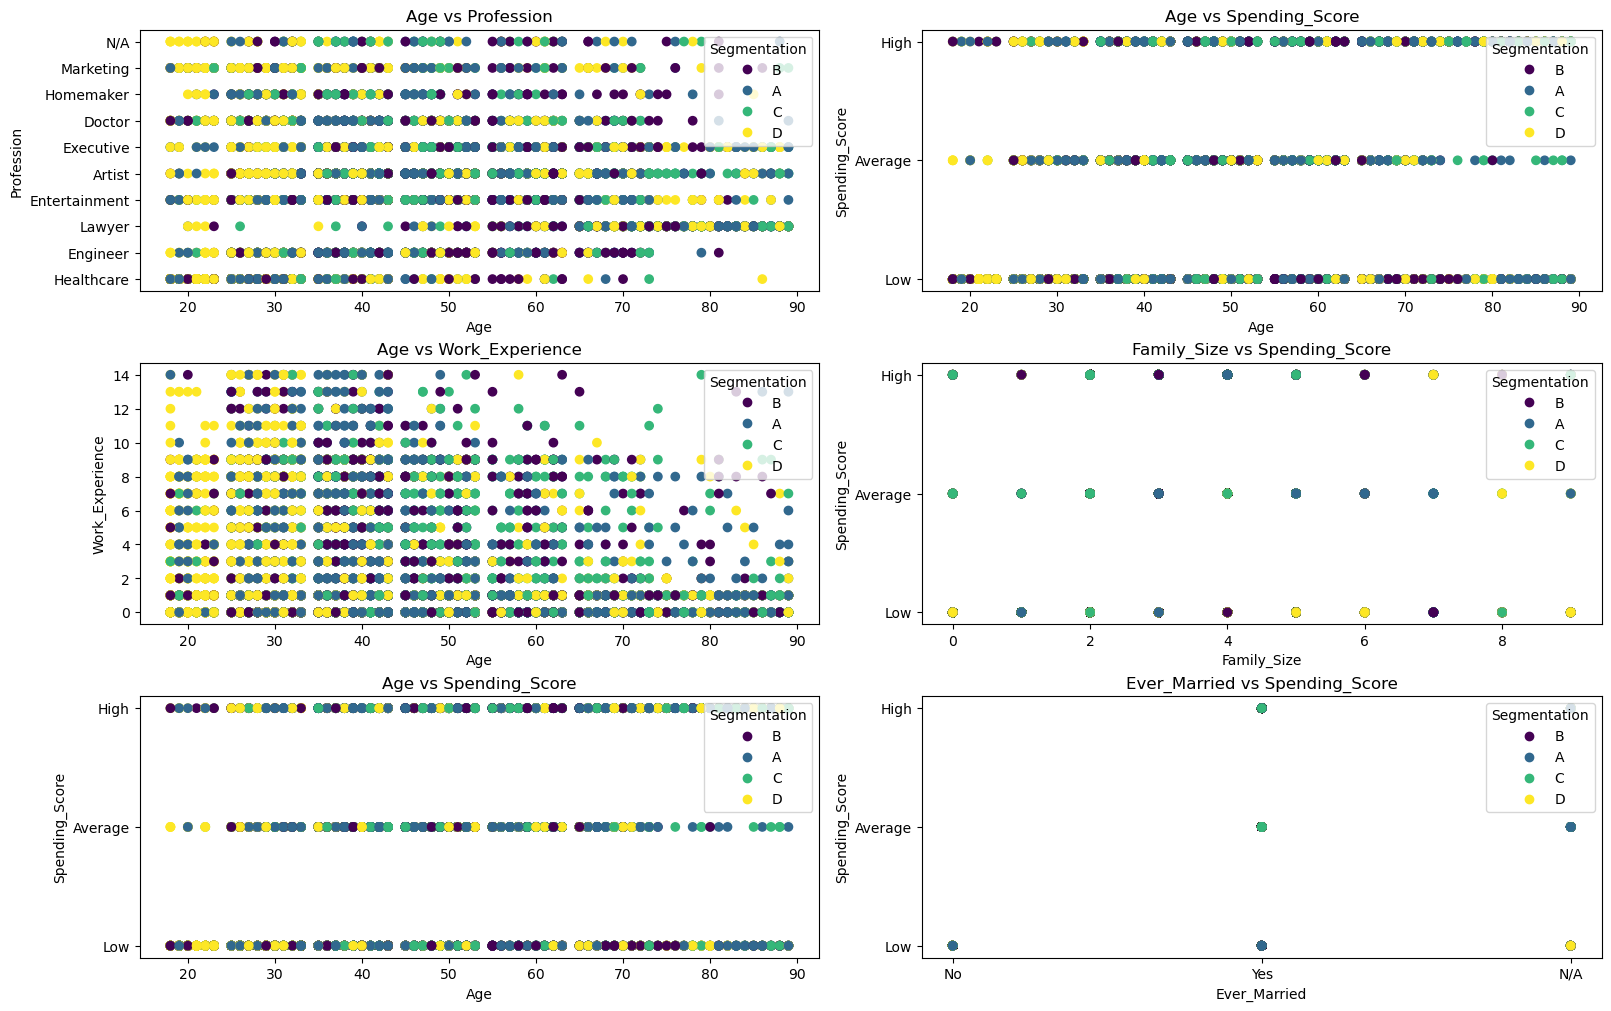

In [3]:
charts = [["Age", "Profession"], ["Age", "Spending_Score"], ["Age", "Work_Experience"], ["Family_Size", "Spending_Score"], ["Age", "Spending_Score"], ["Ever_Married", "Spending_Score"]]
dl.scatter_plots(data_df, charts, "Segmentation")

# Data Preprocessing

In [4]:
features = ["Gender", "Ever_Married", "Age", "Graduated", "Profession", "Work_Experience", "Spending_Score", "Family_Size", "Var_1"]
label = "Segmentation"
categorical_features = ["Gender", "Ever_Married", "Graduated", "Profession", "Spending_Score", "Var_1"]
numerical_features = ["Age", "Work_Experience", "Family_Size"]

# Converting categorical data to numericals
for feature in categorical_features:
    dl.categorical_to_numerical(data_df, feature, True)

dl.categorical_to_numerical(data_df, label, True)

# Normalizing the features
for feature in numerical_features:
    dl.normalize(data_df, feature, True)

In [5]:
# Showing Result of Conversion and Feature Normalization
data_df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,1,1,-1.282499,1,5,-0.408248,2,0.792889,3,3
1,462643,0,2,-0.328606,2,2,-0.710471,0,0.171055,3,0
2,466315,0,2,1.400325,2,2,-0.408248,2,-1.072613,5,1
3,461735,1,2,1.400325,2,7,-0.710471,1,-0.450779,5,1
4,462669,0,2,-0.209369,2,3,-0.710471,1,2.036557,5,0


# Splitting Data

In [6]:
train_df, test_df = dl.train_test_split(data_df, 0.8)
print(f'Data Set Sizes: {train_df.shape, test_df.shape}')
train_X = np.array(train_df[features])
train_y = np.array(train_df[label])
test_X = np.array(test_df[features])
test_y = np.array(test_df[label])
print(f'Train Size: {train_X.shape, train_y.shape}')
print(f'Test Size: {test_X.shape, test_y.shape}')

# Shuffling the data
train_X, train_y = shuffle(train_X, train_y)

Data Set Sizes: ((8556, 11), (2139, 11))
Train Size: ((8556, 9), (8556,))
Test Size: ((2139, 9), (2139,))


# Model Building and Training

In [101]:
import NN
importlib.reload(NN)

<module 'NN' from 'd:\\Work\\Programming\\Jupyter\\Customer Segmentation NN\\NN.py'>

In [72]:
n = features.__len__()
num_labels = np.unique(data_df[label]).__len__()
layers = [
    NN.DenseLayer(n, 0, 'None', is_input = True, is_output = False),
    NN.DenseLayer(32, n, 'sigmoid'),
    NN.DenseLayer(64, 32, 'sigmoid'),
    NN.DenseLayer(64, 64, 'sigmoid'),
    NN.DenseLayer(64, 64, 'sigmoid'),
    NN.DenseLayer(64, 64, 'sigmoid'),
    NN.DenseLayer(32, 64, 'sigmoid'),
    NN.DenseLayer(num_labels, 32, 'sigmoid', is_input = False, is_output = True)
]
learning_rate = 0.005
lamda = 0.01
epochs = 100
batch_size = 16

In [73]:
history = NN.train(layers, 
    train_X, 
    train_y, 
    num_labels, 
    epochs, 
    batch_size,
    learning_rate, 
    lamda,
    test_X,
    test_y,
    True,
    display_method = lambda x: display(x),
    epoch_operation = lambda: clear_output(wait=False))

'Epoch: 99 -> Loss: 0.48, Validation Loss: 0.5'

100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


In [ ]:
# # Checking gradient
# NN.check_gradient(layers,
#     1E-4,
#     train_X,
#     train_y,
#     num_labels,
#     alpha = learning_rate,
#     lamda = lamda)

Text(0, 0.5, 'Loss')

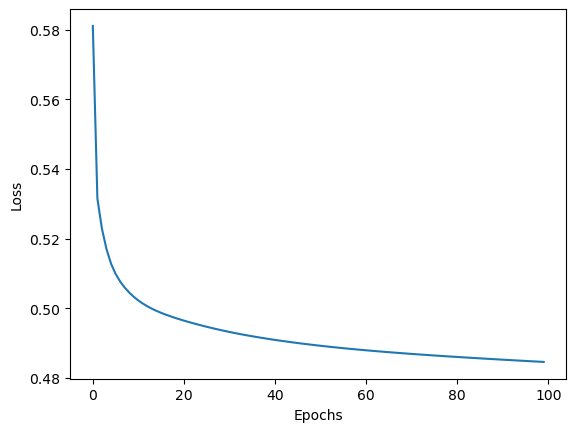

In [74]:
plt.plot(history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Evaluating Model on Confusion Matrix

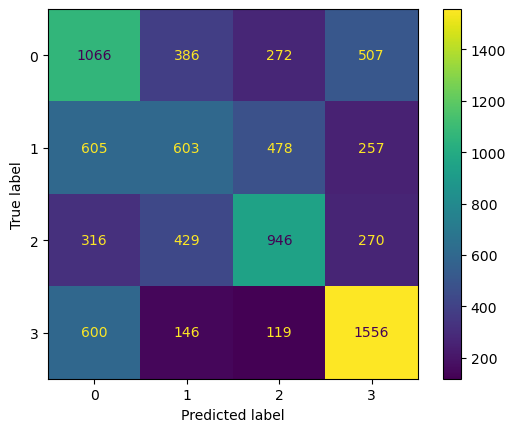

In [81]:
raw_predictions, caches = NN.forward_propagate(layers, train_X)
predictions = np.argmax(raw_predictions, 1)
actual = train_y
confusion_matrix = metrics.confusion_matrix(actual, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

In [77]:
NN.save_model(layers, "model.h5")

In [120]:
loaded_layers = NN.load_model("model.h5")

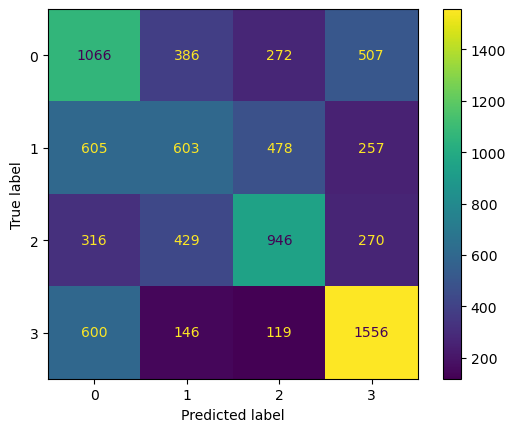

In [123]:
raw_predictions, caches = NN.forward_propagate(loaded_layers, train_X)
predictions = np.argmax(raw_predictions, 1)
actual = train_y
confusion_matrix = metrics.confusion_matrix(actual, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()